# Active Learning Using A Framework

This notebook is meant as an example of using an existing python framework to perform active learning. This could potentially make it easier to try many different algorithms and query strategies, as a coding structure for making it easy to replace parts is predefined, as well as implementations of common methods are given, but it requires that the user learns how to take advantage of the framework.

As a word of caution, in case you find using the framework presented here confusing, for future work you might work be better off implementing the methods yourself.

The framework that we will take a look at is the python package modAL ([github](https://github.com/modAL-python/modAL/tree/dev), [docs](https://modal-python.readthedocs.io/en/latest/)). You should go ahead and read the examples found on github, and if you feel adventurous, you can already take a look at the documentation too, where you can explore the implemented algorithms and how to add your own.

You can find the installation details [here](https://github.com/modAL-python/modAL/tree/dev#installation), but it should simply be: 

`pip install modAL`


We give an example of implementating a Query-by-Committee algorithm using a pool-based scenario in the rest of this notebook going through these steps:

1. Train a passive learner (random sampling from the pool) while evaluating its accuracy on a test set
1. Create several committees of learners with a varying number of committee members
1. Train these committees and evaluate accuracy on the test set
1. Compare the learning curves between the passive learner and the different committees

You should first read the implementation, try to change things, and run it to get an understand of how it all works. When you feel confident in using the code, you should do the exercise and compare the performances of the different methods.

# Questions
<font color=blue>
How is the performance and computational complexity affected by the number of learners?<br>
<font color=green>As the model has to be trained and evaluated on the entire pool for each of the committee members the complexity grows approximately linearly with the number of committee members. Fortunately, this can easily be done in parallel.<br>
<font color=blue>Does the curve change in case another uncertainty sampling metric is used.<br>
<font color=green>In this case we have more than one class so the different metrics may not lead to same samples being chosen (see the plot for three classes in the presentation), however in practice it appears that there is not much difference in this case.<br>
<font color=blue>How are the active learners dependent on the amount of initial labeled data?<br>
<font color=green>This is related to how well the model is able to make predictions about which points to include, when very few points are included initially the estimated uncertainty of samples to use can be very bad as the models are by no mean converged and therefore also produce "strange" uncertainty estimates. There is then a regime where there will be a benefit (of course still depending on the setting and presence of outliers etc.) where there will be a benefit, however in the other extreme where the model has already enough data is esstentially converged and it will make little or no difference what additional data is acquired.<br>
<br>
<font color=blue>
    
If you have more time, you can also try to do the following:
- Try to exchange the classification algorithm and rerun, choose for example the SVC and again induce randomness via bagging (bootstrap).<br>
- Run on a different data set
- Try different approaches to make the base learner differ (see ***the base model and randomness*** below)

<font color=black>
    
### Implementation
Be aware of these details of the implementation.

**The base model and randomness**:

It is important that different committee members/learners differ in their hypothesis/parameters, so we get a exploration of the version space. If the fitting algorithm is not inherently random, i.e., if given the same data it estimates identical parameters every time, the data should be resampled to fit the learners on different data. As you have seen, this can be done by using bagging.

The example below uses a [random forest classifier](https://scikit-learn.org/stable/modules/ensemble.html#forest) as the base learner for the committee, which is an ensemble method using bagging already. You can take a look at the [parameters](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to control how different the models become. ***Hint***: The number of trees `n_estimators` is important for this.

You can also change the resampling to use bagging, and then use any learner you would like to try.


**required packages**:

The notebook uses the following packages to implement the example

- Pandas : to store and evaluate the results
- joblib (optional) : to speed up the experiment by running it parallel
- tqdm : progress bar to keep track of run times.

***Note that it will take quite some time to run some of the code in particular for the larger committees. So equip yourself with patience and perhaps coffee and/or sweets ;)***

## Setup

In [1]:
from collections import namedtuple
import pandas as pd
import numpy as np
import sys
#!{sys.executable} -m pip install tqdm
#!{sys.executable} -m pip install modAL

from modAL.disagreement import vote_entropy_sampling
from modAL.models import ActiveLearner, Committee

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm, trange
#the line above may fail on google colab so you can use the line below in that case but progress bars will looks less nice
#from tqdm import tqdm, trange
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

ModelClass=RandomForestClassifier


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

ResultsRecord = namedtuple('ResultsRecord', ['estimator', 'query_id', 'score'])

## Experiment parameters

In [2]:
SEED = 1 # Set our RNG seed for reproducibility.

n_queries = 75 # You can lower this to decrease run time

# You can increase this to get error bars on your evaluation.
# You probably need to use the parallel code to make this reasonable to compute
n_repeats = 3

## Load Data

In [3]:
from sklearn.datasets import load_iris, load_digits

# loading the data dataset
data_set = load_digits()
X = data_set['data']
y = data_set['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, random_state=SEED)

In [4]:
# in case repetitions are desired
permutations=[np.random.permutation(X_train.shape[0]) for _ in range(n_repeats)]

## Passive Learner

In [5]:
random_results = []

for i_repeat in tqdm(range(n_repeats)):
    learner = ModelClass()
    for i_query in tqdm(range(1,n_queries),leave=False):
        query_indices=permutations[i_repeat][:1+i_query]
        learner=learner.fit(X=X_train[query_indices, :], y=y_train[query_indices])
        score = learner.score(X_test, y_test)
        
        random_results.append(ResultsRecord('random', i_query, score))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

## A committee

In [6]:
n_members=[2, 4, 8, 16]

In [7]:
# SEQUENTIAL VERSION OF THE NEXT CELL
# SLOWER BUT EASIER TO USE IF YOU ARE UNFAMILIAR WITH PARALLEL PROGRAMMING IN PYTHON

committee_results = []

for i_repeat in tqdm(range(n_repeats)):
    for i_members in tqdm(n_members, desc=f'Round (no. members) {i_repeat}',leave=False):
        X_pool = X_train.copy()
        y_pool = y_train.copy()

        start_indices = permutations[i_repeat][:1]

        committee_members = [ActiveLearner(estimator=ModelClass(),
                                           X_training=X_train[start_indices, :],
                                           y_training=y_train[start_indices],
                                           ) for _ in range(i_members)]

        committee = Committee(learner_list=committee_members,
                              query_strategy=vote_entropy_sampling)

        X_pool = np.delete(X_pool, start_indices, axis=0)
        y_pool = np.delete(y_pool, start_indices)

        for i_query in tqdm(range(1, n_queries),desc=f'Points {i_repeat}',leave=False):
            query_idx, query_instance = committee.query(X_pool)

            committee.teach(
                X=X_pool[query_idx].reshape(1, -1),
                y=y_pool[query_idx].reshape(1, )
            )
            committee._set_classes() #this is needed to update for unknown class labels

            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)

            score = committee.score(X_test, y_test)

            committee_results.append(ResultsRecord(
                f'committe_{i_members}',
                i_query,
                score))


  0%|          | 0/3 [00:00<?, ?it/s]

Round (no. members) 0:   0%|          | 0/4 [00:00<?, ?it/s]

Points 0:   0%|          | 0/74 [00:00<?, ?it/s]

Points 0:   0%|          | 0/74 [00:00<?, ?it/s]

Points 0:   0%|          | 0/74 [00:00<?, ?it/s]

Points 0:   0%|          | 0/74 [00:00<?, ?it/s]

Round (no. members) 1:   0%|          | 0/4 [00:00<?, ?it/s]

Points 1:   0%|          | 0/74 [00:00<?, ?it/s]

Points 1:   0%|          | 0/74 [00:00<?, ?it/s]

Points 1:   0%|          | 0/74 [00:00<?, ?it/s]

Points 1:   0%|          | 0/74 [00:00<?, ?it/s]

Round (no. members) 2:   0%|          | 0/4 [00:00<?, ?it/s]

Points 2:   0%|          | 0/74 [00:00<?, ?it/s]

Points 2:   0%|          | 0/74 [00:00<?, ?it/s]

Points 2:   0%|          | 0/74 [00:00<?, ?it/s]

Points 2:   0%|          | 0/74 [00:00<?, ?it/s]

In [8]:
# PARRALLEL VERSION OF THE CELL ABOVE
# Use this instead if you aren't afraid of working with parallel code or want to learn.

from joblib import Parallel, delayed
import itertools as it


def train_committee(i_repeat, i_members, X_train, y_train):
    committee_results = []
    print('') # progress bars won't be displayed if not included

    X_pool = X_train.copy()
    y_pool = y_train.copy()

    start_indices = permutations[i_repeat][:1]

    committee_members = [ActiveLearner(estimator=ModelClass(),
                                       X_training=X_train[start_indices, :],
                                       y_training=y_train[start_indices],
                                       ) for _ in range(i_members)]

    committee = Committee(learner_list=committee_members,
                          query_strategy=vote_entropy_sampling)

    X_pool = np.delete(X_pool, start_indices, axis=0)
    y_pool = np.delete(y_pool, start_indices)

    for i_query in tqdm(range(1, n_queries), desc=f'Round {i_repeat} with {i_members} members', leave=False):
        query_idx, query_instance = committee.query(X_pool)

        committee.teach(
            X=X_pool[query_idx].reshape(1, -1),
            y=y_pool[query_idx].reshape(1, )
        )
        committee._set_classes() #this is needed to update for unknown class labels

        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)

        score = committee.score(X_test, y_test)

        committee_results.append(ResultsRecord(
            f'committe_{i_members}',
            i_query,
            score))

    return committee_results


result = Parallel(n_jobs=-1)(delayed(train_committee)(i,i_members,X_train,y_train)
                    for i, i_members in it.product(range(n_repeats), n_members))

print('All jobs done')
committee_results=[r for rs in result for r in rs]


All jobs done


# Compare the results

In [9]:
df_results = pd.concat([pd.DataFrame(results)
                        for results in
                        [random_results, committee_results]])

In [10]:
df_results.head()

,estimator,query_id,score
0,random,1,0.190317
1,random,2,0.208681
2,random,3,0.322204
3,random,4,0.305509
4,random,5,0.407346


**Exercise**: Plot the `score` column for each `estimator` as a function of the `query_id`. 

If you used `n_repeats>1` then remember to take the mean of the score for each combination of `query_id` and `estimator`, and add error bars if you can.

You can extract the results either by using `df_results.values` or use pandas directly for plotting.

Plotting from a pandas dataframe using `df.plot()` plots a line for each column, so you should change the dataframe accordingly. See [this link](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html) on how to reshape a dataframe.

Otherwise simple numpy arrays and matplotlib works fine.

In [11]:
df_results.values

array([['random', 1, 0.19031719532554256],
       ['random', 2, 0.20868113522537562],
       ['random', 3, 0.32220367278797996],
       ...,
       ['committe_16', 72, 0.9415692821368948],
       ['committe_16', 73, 0.9348914858096828],
       ['committe_16', 74, 0.9332220367278798]], dtype=object)

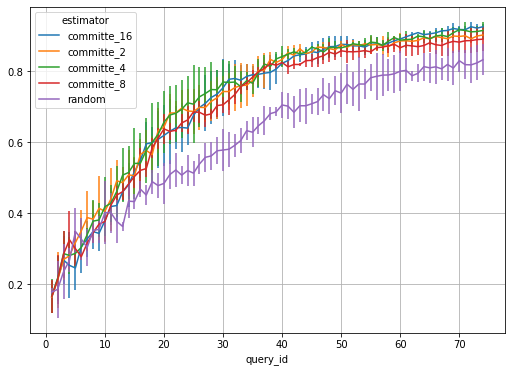

In [12]:
# PANDAS SOLUTION

df_results_mean=df_results.groupby(['estimator','query_id']).mean()
df_results_std=df_results.groupby(['estimator','query_id']).std()

df_mean=df_results_mean.reset_index().pivot(index='query_id', columns='estimator', values='score')
df_std=df_results_std.reset_index().pivot(index='query_id', columns='estimator', values='score')

df_mean.plot(figsize=(8.5,6), yerr=df_std)
plt.grid('on')